In [1]:
!pip install yfinance
!pip install yahoofinancials

IMPORTING LIBRARIES

In [2]:
import numpy as np
import math as m
import pandas as pd
import datetime
import time
import sklearn
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import yfinance as yf
from yahoofinancials import YahooFinancials

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Input file path
file =(r'C:\Users\Gaurav\Desktop\factorDataSetDjia14Yrs.csv')


IMPORTING DATSET

In [3]:

def df_dataset():
    
    global df
    df = pd.read_csv(file, index_col=1)
    # Converting the index as date
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    return df

df_dataset()

,Unnamed: 0,PERMNO,GVKEY,CUSIP,TICKER,NAME,RETURN.OLD,RETURN,RETURN.DIFF,GSECTOR,SECTORNAMES,SECTOR,MKTCAP,ENTVAL,P2B,EV2S,SIZE
DATE,,,,,,,,,,,,,,,,,
2004-05-01,1,24643,1356,13817101,AA,ALCOA INC,0.022764,0.022816,0.0,15,Materials,MATRLS,28.730683,35.145683,2.351120,1.501696,10.265721
2004-05-01,2,19561,2285,97023105,BA,BOEING CO,0.077536,0.077862,0.0,20,Industrials,INDUST,40.820297,48.295297,4.561437,0.922511,10.616935
2004-05-01,3,59408,7647,60505104,BAC,BANK OF AMERICA CORP,0.032799,0.032799,0.0,40,Financials,FINS,171.890975,335.324975,1.799924,5.058302,12.054616
2004-05-01,4,18542,2817,149123101,CAT,CATERPILLAR INC,-0.030619,-0.030619,0.0,20,Industrials,INDUST,27.226630,48.173630,4.119006,1.588211,10.211951
2004-05-01,5,14541,2991,166764100,CVX,CHEVRON CORP,-0.004044,-0.004179,0.0,10,Energy,ENERGY,100.234114,103.022114,2.443185,0.743134,11.515264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-01,2350,66093,9899,00206R102,T,AT&T INC,0.021721,0.021721,0.0,50,Telecommunications,TELCOM,198.962752,269.128752,2.260992,2.145752,12.200873
2013-03-01,2351,17830,10983,913017109,UTX,UNITED TECHNOLOGIES CORP,0.031806,0.031806,0.0,20,Industrials,INDUST,85.890292,103.947292,3.279006,1.804766,11.360826
2013-03-01,2352,65875,2136,92343V104,VZ,VERIZON COMMUNICATIONS INC,0.056308,0.056308,0.0,50,Telecommunications,TELCOM,140.618150,187.364150,4.221500,1.592149,11.853803


In [4]:
#create set and list of all tickers
myset_ticker = set(df.TICKER)
list_tickers = list(myset_ticker)

In [5]:
#create the dictionary with values and keys as dates
keys = df['TICKER']
values = df['SECTORNAMES']
Dictionary_Sector_values = dict(zip(keys, values))
Dictionary_Sector_values

{'AA': 'Materials',
 'BA': 'Industrials',
 'BAC': 'Financials',
 'CAT': 'Industrials',
 'CVX': 'Energy',
 'DD': 'Materials',
 'GE': 'Industrials',
 'HPQ': 'InformationTechnology',
 'IBM': 'InformationTechnology',
 'INTC': 'InformationTechnology',
 'JNJ': 'HealthCare',
 'JPM': 'Financials',
 'KO': 'ConsumerStaples',
 'MMM': 'Industrials',
 'MRK': 'HealthCare',
 'PFE': 'HealthCare',
 'PG': 'ConsumerStaples',
 'T': 'Telecommunications',
 'UTX': 'Industrials',
 'VZ': 'Telecommunications',
 'WMT': 'ConsumerStaples',
 'XOM': 'Energy'}

In [6]:
#create df and list of all months dates
df_dates = df.index
df_dates = df_dates.unique()
df_dates = df_dates.sort_values()
list_dates = df_dates.tolist()

FACTOR INPUTS AND Z-SCORES

In [7]:

def final_df():
    
    t0 = time.time()

    # Settings for building df_final dataframe containing factor inputs and Z-scores

    f_date = datetime.date(2004, 5, 1) 
    l_date = datetime.date(2013, 3, 1) #choosing the last date

    delta = l_date - f_date
    month_delta = np.floor(delta.days/(365/12))
    month_delta = int(month_delta)

    #choose if you want percentiles or fixed number of companies in long portfolio
    global Percentile_split
    
    Percentile_split = .1

    Winsorize_Threshold = .001 #used to determine the winsorize level. If you are
    #only going to have a handful of companies than put the threshold really low, 
    #otherwise you can use around .025 for a decile portfolio

    global df_final

    df_final = pd.DataFrame()

    for i in range(0, month_delta+1):


        #filter the data for only current date to look at
        Date = f_date + pd.tseries.offsets.DateOffset(months=i)
        Date = Date.strftime('%Y-%m-%d')
        df_master_filter = df.loc[df.index == Date]

        ###### VALUE FACTOR ######

        #Winsorize the metric data and compress outliers if desired
        df_master_filter['P2B Winsorized'] = stats.mstats.winsorize(df_master_filter['P2B'], limits=Winsorize_Threshold)
        df_master_filter['EV2S Winsorized'] = stats.mstats.winsorize(df_master_filter['EV2S'], limits=Winsorize_Threshold)

        #create Z score to normalize the metrics
        df_master_filter['P2B Z score'] = stats.zscore(df_master_filter['P2B Winsorized'])
        df_master_filter['EV2S Z score'] = stats.zscore(df_master_filter['EV2S Winsorized'])

        #composite valuation score
        df_master_filter['Valuation Score'] = df_master_filter['P2B Z score'] + df_master_filter['EV2S Z score']


        ###### LOW VOLATILITY FACTOR ######

        df_vol = df.pivot(columns='TICKER', values='RETURN')

        #create rolling vol metric for previous 1 year
        df_rolling_vol = df_vol.rolling(12).std()

        Filter_Vol_Signal = df_rolling_vol.loc[Date]
        #Filter_Vol_Signal_Sort = Filter_Vol_Signal.sort_values()
        #Filter_Vol_Signal_Sort

        #create z score and rank for the Volatility Factor
        frame = { 'Vol': Filter_Vol_Signal} 
        Filter_Vol_Signal_df = pd.DataFrame(frame)
        Filter_Vol_Signal_df['Vol Z Score'] = stats.zscore(Filter_Vol_Signal)
        Filter_Vol_Signal_df = Filter_Vol_Signal_df.reset_index()

        Filter_Vol_Signal_df

        df_master_filter = pd.merge(df_master_filter, Filter_Vol_Signal_df, on=['TICKER'], how='inner')

        ###### MOMENTUM FACTOR #####

        df_mom = df.pivot(columns='TICKER', values='RETURN')

        df_mom = df_mom.apply(lambda x: x+1)

        df_rolling_mom = df_mom.rolling(window=12).apply(np.prod) - 1

        df_rolling_mom

        Filter_mom_Signal = df_rolling_mom.loc[Date]

        Filter_mom_Signal

        #create z score and rank for the Momentum Factor
        frame1 = {'Momentum': Filter_mom_Signal} 
        Filter_mom_Signal_df = pd.DataFrame(frame)
        Filter_mom_Signal_df['Momentum Z Score'] = stats.zscore(Filter_mom_Signal)
        Filter_mom_Signal_df = Filter_mom_Signal_df.rename(columns={0: "Momentum"})
        Filter_mom_Signal_df = Filter_mom_Signal_df.reset_index()

        Filter_mom_Signal_df

        ### Create Composite Score from factors ###

        #Because we made all the factors with a z score, each factor should have equal
        #weight in the composite. We can consider changing the weights based on 
        #historical statistical significance or whatever else seems reasonable

        df_master_filter = pd.merge(df_master_filter, Filter_mom_Signal_df[['TICKER','Momentum Z Score']], on=['TICKER'], how='inner')

        df_master_filter['Total Score'] = df_master_filter['Momentum Z Score'] - df_master_filter['Valuation Score'] - df_master_filter['Vol Z Score'] 

        df_final = df_final.append(df_master_filter)


    df_final = df_final.set_index(df.index).drop(df.columns[[0, 1, 2, 3, 9, 11]], axis = 1)
    df_final = df_final.dropna()
    t1 = time.time()
    total = t1 - t0
    return df_final

final_df()



,TICKER,NAME,RETURN.OLD,RETURN,RETURN.DIFF,SECTORNAMES,MKTCAP,ENTVAL,P2B,EV2S,SIZE,P2B Winsorized,EV2S Winsorized,P2B Z score,EV2S Z score,Valuation Score,Vol,Vol Z Score,Momentum Z Score,Total Score
DATE,,,,,,,,,,,,,,,,,,,,
2005-04-01,AA,ALCOA INC,-0.045081,-0.045081,0.0,Materials,22.791814,29.258814,1.713541,1.141139,10.034157,1.713541,1.141139,-1.214162,-0.898394,-2.112556,0.054642,0.108346,-0.486989,1.517221
2005-04-01,BA,BOEING CO,0.018132,0.018132,0.0,Industrials,51.502044,57.366044,4.626486,0.976676,10.849377,4.626486,0.976676,0.645297,-1.019883,-0.374586,0.052918,0.026422,2.020489,2.368653
2005-04-01,BAC,BANK OF AMERICA CORP,0.021315,0.021315,0.0,Financials,183.201869,388.664869,1.827104,4.509501,12.118344,1.827104,4.509501,-1.141671,1.589817,0.448147,0.029451,-1.089172,0.620792,1.261817
2005-04-01,CAT,CATERPILLAR INC,-0.032590,-0.032568,0.0,Industrials,32.251760,55.979760,4.185822,1.495186,10.381328,4.185822,1.495186,0.364002,-0.636859,-0.272858,0.070399,0.857444,0.571754,-0.012832
2005-04-01,CVX,CHEVRON CORP,-0.108215,-0.108215,0.0,Energy,116.535323,114.327323,2.401057,0.633701,11.665950,2.401057,0.633701,-0.775291,-1.273239,-2.048530,0.068626,0.773150,0.666192,1.941571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-01,T,AT&T INC,0.021721,0.021721,0.0,Telecommunications,198.962752,269.128752,2.260992,2.145752,12.200873,2.260992,2.145752,-0.430926,-0.037047,-0.467973,0.043482,-0.475494,0.725903,1.669370
2013-03-01,UTX,UNITED TECHNOLOGIES CORP,0.031806,0.031806,0.0,Industrials,85.890292,103.947292,3.279006,1.804766,11.360826,3.279006,1.804766,-0.041452,-0.330832,-0.372284,0.044581,-0.427865,0.196172,0.996321
2013-03-01,VZ,VERIZON COMMUNICATIONS INC,0.056308,0.056308,0.0,Telecommunications,140.618150,187.364150,4.221500,1.592149,11.853803,4.221500,1.592149,0.319129,-0.514017,-0.194888,0.040318,-0.612546,1.466169,2.273603


VALUE FACTOR (FUNDAMENTAL FACTOR)

In [8]:

def value_ret(lag):
    
    ## Value (fundamental) factor returns

    global df_value 
    
    df_value = df_final.pivot(columns='TICKER', values='Valuation Score')
    
    number_firms = df_value.shape
    number_firms = number_firms[1]

    firms_in_percentile = np.round(Percentile_split * number_firms)
    firms_in_percentile

    # maxValueIndexObj = df_value.idxmax(axis=1)
    # minValueIndexObj = df_value.idxmin(axis=1)

    #index_no = df.columns.get_loc(col_name)
    a = df_value.apply(lambda row: row.nlargest(2).index,axis=1)
    b = df_value.apply(lambda row: row.nsmallest(2).index,axis=1)
    
    global df_value_ret
    
    df_value_ret = df_final.pivot(columns='TICKER', values='RETURN')
    df_value_ret = df_value_ret.iloc[:,:22].shift(-lag)
    df_value_ret

    df_value_ret['First ticker for long portfolio'] = [b[i][0] for i in range(len(b))]
    df_value_ret['Second ticker for long portfolio'] = [b[i][1] for i in range(len(b))]
    df_value_ret['First ticker return long'] = [df_value_ret.iloc[i, df_value_ret.columns.get_loc(b[i][0])] for i in range(len(b))]
    df_value_ret['Second ticker return long'] = [df_value_ret.iloc[i, df_value_ret.columns.get_loc(b[i][1])] for i in range(len(b))]
    df_value_ret['Value Long Portfolio return'] = (df_value_ret['First ticker return long'] + df_value_ret['Second ticker return long'])/2

    df_value_ret['First ticker for short portfolio'] = [a[i][0] for i in range(len(a))]
    df_value_ret['Second ticker for short portfolio'] = [a[i][1] for i in range(len(a))]
    df_value_ret['First ticker return short'] = [-df_value_ret.iloc[i, df_value_ret.columns.get_loc(a[i][0])] for i in range(len(a))]
    df_value_ret['Second ticker return short'] = [-df_value_ret.iloc[i, df_value_ret.columns.get_loc(a[i][1])] for i in range(len(a))]
    df_value_ret['Value Short Portfolio return'] = (df_value_ret['First ticker return short'] + df_value_ret['Second ticker return short'])/2
    
    # ValR = df_value_ret['Value L/S Portfolio return'].agg(lambda x: (x + 1).prod() - 1)
    # ValR
    
    df_value_ret['Value L/S Portfolio return'] = df_value_ret['Value Long Portfolio return'] + df_value_ret['Value Short Portfolio return']
    return df_value_ret

value_ret(1)


TICKER,AA,BA,BAC,CAT,CVX,DD,GE,HPQ,IBM,INTC,...,Second ticker for long portfolio,First ticker return long,Second ticker return long,Value Long Portfolio return,First ticker for short portfolio,Second ticker for short portfolio,First ticker return short,Second ticker return short,Value Short Portfolio return,Value L/S Portfolio return
DATE,,,,,,,,,,,,,,,,,,,,,
2005-04-01,-0.061356,0.078004,0.028419,0.068825,0.043528,-0.005000,0.007735,0.099658,-0.008239,0.150120,...,AA,0.099658,-0.061356,0.019151,KO,PG,-0.027394,-0.018467,-0.022930,-0.003779
2005-05-01,-0.035793,0.032864,-0.005668,0.012751,0.039792,-0.075253,-0.044278,0.047992,-0.017869,-0.034866,...,AA,0.047992,-0.035793,0.006100,KO,PG,0.058533,0.043518,0.051026,0.057125
2005-06-01,0.073479,0.000152,-0.044069,0.136577,0.037375,-0.007673,-0.004329,0.047214,0.124798,0.043044,...,AA,0.047214,0.073479,0.060346,KO,PG,-0.048144,-0.060005,-0.054074,0.006272
2005-07-01,-0.039912,0.019096,-0.001490,0.029308,0.066312,-0.064727,-0.025797,0.127538,-0.031705,-0.049562,...,AA,0.127538,-0.039912,0.043813,PG,KO,0.002696,-0.005485,-0.001395,0.042419
2005-08-01,-0.088466,0.013876,-0.021613,0.058749,0.054235,-0.010109,0.008398,0.054908,-0.004962,-0.041602,...,HPQ,-0.088466,0.054908,-0.016779,PG,KO,-0.071738,0.012158,-0.029790,-0.046569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,0.032105,0.014540,0.178674,0.057323,0.023181,0.042652,0.002440,0.107486,0.007787,0.053654,...,HPQ,0.032105,0.107486,0.069795,IBM,KO,-0.007787,0.044040,0.018126,0.087922
2012-12-01,0.018433,-0.019772,-0.024978,0.097980,0.064823,0.054913,0.061458,0.158596,0.060141,0.020369,...,HPQ,0.018433,0.158596,0.088515,IBM,KO,-0.060141,-0.027310,-0.043726,0.044789
2013-01-01,-0.032954,0.047705,-0.007058,-0.061185,0.025289,0.018613,0.050718,0.219867,-0.006868,0.003061,...,HPQ,-0.032954,0.219867,0.093456,IBM,KO,0.006868,-0.039742,-0.016437,0.077019


VOL FACTOR

In [9]:

def vol_ret(lag):

    ## Vol factor returns ##

    df_vol_factor = df_final.pivot(columns='TICKER', values='Vol Z Score')

    number_firms = df_value.shape
    number_firms = number_firms[1]

    firms_in_percentile = np.round(Percentile_split * number_firms)
    firms_in_percentile

    #index_no = df.columns.get_loc(col_name)
    c = df_vol_factor.apply(lambda row: row.nlargest(2).index,axis=1)
    d = df_vol_factor.apply(lambda row: row.nsmallest(2).index,axis=1)
    
    global df_vol_ret

    df_vol_ret = df_final.pivot(columns='TICKER', values='RETURN')
    df_vol_ret = df_vol_ret.iloc[:,:22].shift(-lag)
    df_vol_ret

    df_vol_ret['First ticker for long portfolio'] = [d[i][0] for i in range(len(d))]
    df_vol_ret['Second ticker for long portfolio'] = [d[i][1] for i in range(len(d))]
    df_vol_ret['First ticker return long'] = [df_vol_ret.iloc[i, df_vol_ret.columns.get_loc(d[i][0])] for i in range(len(d))]
    df_vol_ret['Second ticker return long'] = [df_vol_ret.iloc[i, df_vol_ret.columns.get_loc(d[i][1])] for i in range(len(d))]
    df_vol_ret['Vol Long Portfolio return'] = (df_vol_ret['First ticker return long'] + df_vol_ret['Second ticker return long'])/2

    df_vol_ret['First ticker for short portfolio'] = [c[i][0] for i in range(len(c))]
    df_vol_ret['Second ticker for short portfolio'] = [c[i][1] for i in range(len(c))]
    df_vol_ret['First ticker return short'] = [-df_vol_ret.iloc[i, df_vol_ret.columns.get_loc(c[i][0])] for i in range(len(c))]
    df_vol_ret['Second ticker return short'] = [-df_vol_ret.iloc[i, df_vol_ret.columns.get_loc(c[i][1])] for i in range(len(c))]
    df_vol_ret['Vol Short Portfolio return'] = (df_vol_ret['First ticker return short'] + df_vol_ret['Second ticker return short'])/2
    
    # VolR = df_vol_ret['Vol L/S Portfolio return'].agg(lambda x: (x + 1).prod() - 1)
    # VolR
    
    df_vol_ret['Vol L/S Portfolio return'] = df_vol_ret['Vol Long Portfolio return'] + df_vol_ret['Vol Short Portfolio return']
    return df_vol_ret

vol_ret(1)


TICKER,AA,BA,BAC,CAT,CVX,DD,GE,HPQ,IBM,INTC,...,Second ticker for long portfolio,First ticker return long,Second ticker return long,Vol Long Portfolio return,First ticker for short portfolio,Second ticker for short portfolio,First ticker return short,Second ticker return short,Vol Short Portfolio return,Vol L/S Portfolio return
DATE,,,,,,,,,,,,,,,,,,,,,
2005-04-01,-0.061356,0.078004,0.028419,0.068825,0.043528,-0.005000,0.007735,0.099658,-0.008239,0.150120,...,JNJ,0.007735,-0.017501,-0.004883,MRK,INTC,0.043068,-0.150120,-0.053526,-0.058409
2005-05-01,-0.035793,0.032864,-0.005668,0.012751,0.039792,-0.075253,-0.044278,0.047992,-0.017869,-0.034866,...,WMT,-0.044278,0.020538,-0.011870,MRK,INTC,0.039301,0.034866,0.037083,0.025213
2005-06-01,0.073479,0.000152,-0.044069,0.136577,0.037375,-0.007673,-0.004329,0.047214,0.124798,0.043044,...,GE,0.023859,-0.004329,0.009765,MRK,INTC,-0.008442,-0.043044,-0.025743,-0.015978
2005-07-01,-0.039912,0.019096,-0.001490,0.029308,0.066312,-0.064727,-0.025797,0.127538,-0.031705,-0.049562,...,WMT,-0.025797,-0.086075,-0.055936,MRK,INTC,0.078739,0.049562,0.064150,0.008214
2005-08-01,-0.088466,0.013876,-0.021613,0.058749,0.054235,-0.010109,0.008398,0.054908,-0.004962,-0.041602,...,JPM,0.008398,0.001180,0.004789,MRK,XOM,0.036132,-0.060768,-0.012318,-0.007529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,0.032105,0.014540,0.178674,0.057323,0.023181,0.042652,0.002440,0.107486,0.007787,0.053654,...,PFE,0.005306,0.002398,0.003852,BAC,JPM,-0.178674,-0.070351,-0.124512,-0.120661
2012-12-01,0.018433,-0.019772,-0.024978,0.097980,0.064823,0.054913,0.061458,0.158596,0.060141,0.020369,...,PFE,0.054494,0.097226,0.075860,BAC,JPM,0.024978,-0.077399,-0.026210,0.049649
2013-01-01,-0.032954,0.047705,-0.007058,-0.061185,0.025289,0.018613,0.050718,0.219867,-0.006868,0.003061,...,VZ,0.037863,0.066957,0.052410,BAC,JPM,0.007058,-0.039745,-0.016343,0.036067


MOMENTUM FACTOR

In [10]:

def mom_ret(lag):

    ## Momentum factor returns ##

    df_momentum = df_final.pivot(columns='TICKER', values='Momentum Z Score')
    df_momentum

    number_firms = df_value.shape
    number_firms = number_firms[1]

    firms_in_percentile = np.round(Percentile_split * number_firms)
    firms_in_percentile

    #index_no = df.columns.get_loc(col_name)
    e = df_momentum.apply(lambda row: row.nlargest(2).index,axis=1)
    f = df_momentum.apply(lambda row: row.nsmallest(2).index,axis=1)
    
    global df_mom_ret

    df_mom_ret = df_final.pivot(columns='TICKER', values='RETURN')
    df_mom_ret = df_mom_ret.iloc[:,:22].shift(-lag)

    df_mom_ret['First ticker for long portfolio'] = [e[i][0] for i in range(len(e))]
    df_mom_ret['Second ticker for long portfolio'] = [e[i][1] for i in range(len(e))]
    df_mom_ret['First ticker return long'] = [df_mom_ret.iloc[i, df_mom_ret.columns.get_loc(e[i][0])] for i in range(len(e))]
    df_mom_ret['Second ticker return long'] = [df_mom_ret.iloc[i, df_mom_ret.columns.get_loc(e[i][1])] for i in range(len(e))]
    df_mom_ret['Momentum Long Portfolio return'] = (df_mom_ret['First ticker return long'] + df_mom_ret['Second ticker return long'])/2

    df_mom_ret['First ticker for short portfolio'] = [f[i][0] for i in range(len(f))]
    df_mom_ret['Second ticker for short portfolio'] = [f[i][1] for i in range(len(f))]
    df_mom_ret['First ticker return short'] = [-df_mom_ret.iloc[i, df_mom_ret.columns.get_loc(f[i][0])] for i in range(len(f))]
    df_mom_ret['Second ticker return short'] = [-df_mom_ret.iloc[i, df_mom_ret.columns.get_loc(f[i][1])] for i in range(len(f))]
    df_mom_ret['Momentum Short Portfolio return'] = (df_mom_ret['First ticker return short'] + df_mom_ret['Second ticker return short'])/2

    df_mom_ret['Momentum L/S Portfolio return'] = df_mom_ret['Momentum Long Portfolio return'] + df_mom_ret['Momentum Short Portfolio return']
    df_mom_ret['Equal weight return'] = df_mom_ret.iloc[:, :22].mean(axis=1)
    
    # MR = df_mom_ret['Momentum L/S Portfolio return'].agg(lambda x: (x + 1).prod() - 1)
    # MR

    return df_mom_ret

mom_ret(1)


TICKER,AA,BA,BAC,CAT,CVX,DD,GE,HPQ,IBM,INTC,...,First ticker return long,Second ticker return long,Momentum Long Portfolio return,First ticker for short portfolio,Second ticker for short portfolio,First ticker return short,Second ticker return short,Momentum Short Portfolio return,Momentum L/S Portfolio return,Equal weight return
DATE,,,,,,,,,,,,,,,,,,,,,
2005-04-01,-0.061356,0.078004,0.028419,0.068825,0.043528,-0.005000,0.007735,0.099658,-0.008239,0.150120,...,0.078004,-0.009535,0.034234,MRK,PFE,0.043068,-0.033970,0.004549,0.038783,0.020715
2005-05-01,-0.035793,0.032864,-0.005668,0.012751,0.039792,-0.075253,-0.044278,0.047992,-0.017869,-0.034866,...,0.032864,0.022598,0.027731,MRK,PFE,0.039301,0.011470,0.025385,0.053116,-0.015237
2005-06-01,0.073479,0.000152,-0.044069,0.136577,0.037375,-0.007673,-0.004329,0.047214,0.124798,0.043044,...,0.022272,0.000152,0.011212,MRK,AA,-0.008442,-0.073479,-0.040961,-0.029749,0.026782
2005-07-01,-0.039912,0.019096,-0.001490,0.029308,0.066312,-0.064727,-0.025797,0.127538,-0.031705,-0.049562,...,0.029308,0.019096,0.024202,MRK,PFE,0.078739,0.031599,0.055169,0.079371,-0.013373
2005-08-01,-0.088466,0.013876,-0.021613,0.058749,0.054235,-0.010109,0.008398,0.054908,-0.004962,-0.041602,...,0.054908,0.058749,0.056829,MRK,PFE,0.036132,0.020016,0.028074,0.084903,0.005654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,0.032105,0.014540,0.178674,0.057323,0.023181,0.042652,0.002440,0.107486,0.007787,0.053654,...,0.178674,0.002440,0.090557,HPQ,INTC,-0.107486,-0.053654,-0.080570,0.009987,0.018487
2012-12-01,0.018433,-0.019772,-0.024978,0.097980,0.064823,0.054913,0.061458,0.158596,0.060141,0.020369,...,-0.024978,0.077399,0.026210,HPQ,INTC,-0.158596,-0.020369,-0.089483,-0.063272,0.054603
2013-01-01,-0.032954,0.047705,-0.007058,-0.061185,0.025289,0.018613,0.050718,0.219867,-0.006868,0.003061,...,-0.007058,0.003299,-0.001879,HPQ,INTC,-0.219867,-0.003061,-0.111464,-0.113344,0.026046


MARKET FACTOR

In [11]:
def DJIA():
    
    global DJIA_df
    
    DJIA_df = yf.download('^DJI', start='2004-05-03', end='2013-03-31', progress=False)
    DJIA_df.index = DJIA_df.index.map(lambda x:pd.to_datetime(str(x)))
    DJIA_df['Daily Return'] = DJIA_df['Adj Close'].pct_change()
    DJIA_df = DJIA_df['Daily Return'].resample('M').agg(lambda x: (x + 1).prod() - 1)
    
    # DR = DJIA_df.agg(lambda x: (x + 1).prod() - 1)
    # DR
    
    return DJIA_df

DJIA()

Date
2004-05-31   -0.012173
2004-06-30    0.024246
2004-07-31   -0.028343
2004-08-31    0.003374
2004-09-30   -0.009205
                ...   
2012-11-30   -0.005412
2012-12-31    0.006031
2013-01-31    0.057725
2013-02-28    0.013990
2013-03-31    0.037287
Freq: M, Name: Daily Return, Length: 107, dtype: float64

RISK FREE RATE (3M Treasury bill)

In [12]:

def RF():

    global RF_df
    
    RF_df = yf.download('^IRX', start='2004-05-03', end='2013-03-31', progress=False)
    RF_df.index = RF_df.index.map(lambda x:pd.to_datetime(str(x)))
    RF_df = RF_df['Adj Close'].resample('M').agg(np.mean)/1200
    
    return RF_df

RF()

Date
2004-05-31    0.000841
2004-06-30    0.001038
2004-07-31    0.001099
2004-08-31    0.001220
2004-09-30    0.001367
                ...   
2012-11-30    0.000072
2012-12-31    0.000049
2013-01-31    0.000054
2013-02-28    0.000074
2013-03-31    0.000066
Freq: M, Name: Adj Close, Length: 107, dtype: float64

SECTOR FACTOR

In [13]:
df_sector = df.pivot_table(columns='SECTORNAMES', values='RETURN', aggfunc=np.mean)
df_sector

SECTORNAMES,ConsumerStaples,Energy,Financials,HealthCare,Industrials,InformationTechnology,Materials,Telecommunications
RETURN,0.006578,0.011836,0.005418,0.005384,0.009316,0.007,0.001885,0.009054


In [14]:
df_sector = pd.DataFrame()

f_date = datetime.date(2004, 5, 1) 
l_date = datetime.date(2013, 3, 1) #choosing the last date

delta = l_date - f_date
month_delta = np.floor(delta.days/(365/12))
month_delta = int(month_delta)

for i in range(0, month_delta+1):
    

    #filter the data for only current date to look at
    Date = f_date + pd.tseries.offsets.DateOffset(months=i)
    Date = Date.strftime('%Y-%m-%d')
    df_sector_filter = df.loc[df.index == Date]
    
    ###### SECTOR FACTOR ######
    
    df_sector_pivot = df_sector_filter.pivot_table(columns='SECTORNAMES', values='RETURN', aggfunc=np.mean)
    
    df_sector = df_sector.append(df_sector_pivot)
    
df_sector['Date'] = df.index.unique()
first_column = df_sector.pop('Date')
df_sector.insert(0, 'Date', first_column)
df_sector

    

SECTORNAMES,Date,ConsumerStaples,Energy,Financials,HealthCare,Industrials,InformationTechnology,Materials,Telecommunications
RETURN,2004-05-01,0.004880,0.009421,0.006293,0.011937,0.010685,0.065421,0.018558,-0.065962
RETURN,2004-06-01,-0.020095,0.033931,0.040107,-0.006067,0.072566,-0.013722,0.041757,0.034883
RETURN,2004-07-01,-0.053026,0.029461,-0.012007,-0.040220,-0.022686,-0.057981,-0.032585,0.067554
RETURN,2004-08-01,0.029524,0.014750,0.059250,0.025313,0.004271,-0.087577,0.004937,0.018091
RETURN,2004-09-01,-0.040658,0.074341,-0.011579,-0.117917,0.018123,0.002433,0.025073,0.004758
...,...,...,...,...,...,...,...,...,...
RETURN,2012-11-01,-0.001522,-0.030094,0.021773,-0.006921,0.029327,-0.055553,-0.019955,-0.012474
RETURN,2012-12-01,-0.039730,0.002571,0.124512,-0.019759,0.023782,0.056309,0.037378,-0.015786
RETURN,2013-01-01,0.056193,0.052169,0.026210,0.069381,0.058079,0.079702,0.036673,0.032468
RETURN,2013-02-01,0.021726,0.013490,0.016343,0.009713,0.023630,0.072020,-0.007171,0.049575


In [15]:
df_sector.iloc[:,2:].corr()

SECTORNAMES,Energy,Financials,HealthCare,Industrials,InformationTechnology,Materials,Telecommunications
SECTORNAMES,,,,,,,
Energy,1.000000,0.186015,0.341408,0.500481,0.394149,0.451200,0.426491
Financials,0.186015,1.000000,0.435173,0.661155,0.423592,0.610395,0.187172
HealthCare,0.341408,0.435173,1.000000,0.496787,0.380422,0.432297,0.429998
Industrials,0.500481,0.661155,0.496787,1.000000,0.651572,0.841631,0.460435
InformationTechnology,0.394149,0.423592,0.380422,0.651572,1.000000,0.684029,0.319801
Materials,0.451200,0.610395,0.432297,0.841631,0.684029,1.000000,0.438245
Telecommunications,0.426491,0.187172,0.429998,0.460435,0.319801,0.438245,1.000000


FACTORS DATAFRAME USING LONG ONLY PORTFOLIOS

In [17]:
def factor_ret_long():

    df_factor_ret = pd.concat([DJIA_df, RF_df], axis=1)
    df_factor_ret = df_factor_ret.rename({'Daily Return': 'Market Return', 'Adj Close': 'Risk Free Rate'}, axis=1)
    df_factor_ret['Market Factor'] = df_factor_ret['Market Return'] - df_factor_ret['Risk Free Rate']
    df_factor_ret['Date'] = df.index.unique()
    df_factor_ret.set_index('Date', inplace=True)

    global df_factor_ret_long
    
    df_factor_ret_long = pd.merge(df_factor_ret, df_value_ret["Value Long Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret_long = pd.merge(df_factor_ret_long, df_vol_ret["Vol Long Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret_long = pd.merge(df_factor_ret_long, df_mom_ret["Momentum Long Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret_long = df_factor_ret_long.rename({'Value Long Portfolio return': 'Value Long Factor', 'Vol Long Portfolio return': 'Vol Long Factor', 'Momentum Long Portfolio return': 'Momentum Long Factor'}, axis=1).dropna()
    
    return df_factor_ret_long

factor_ret_long()


,Market Return,Risk Free Rate,Market Factor,Value Long Factor,Vol Long Factor,Momentum Long Factor
2005-04-01,-0.029632,0.002306,-0.031938,0.019151,-0.004883,0.034234
2005-05-01,0.026978,0.002350,0.024628,0.006100,-0.011870,0.027731
2005-06-01,-0.018391,0.002469,-0.020860,0.060346,0.009765,0.011212
2005-07-01,0.035615,0.002669,0.032945,0.043813,-0.055936,0.024202
2005-08-01,-0.014972,0.002857,-0.017828,-0.016779,0.004789,0.056829
...,...,...,...,...,...,...
2012-10-01,-0.025353,0.000081,-0.025433,-0.040382,0.019221,0.014396
2012-11-01,-0.005412,0.000072,-0.005484,0.069795,0.003852,0.090557
2012-12-01,0.006031,0.000049,0.005983,0.088515,0.075860,0.026210
2013-01-01,0.057725,0.000054,0.057672,0.093456,0.052410,-0.001879


In [18]:
df_factor_ret_long.iloc[:,2:].corr()

,Market Factor,Value Long Factor,Vol Long Factor,Momentum Long Factor
Market Factor,1.000000,0.188194,0.082572,-0.009250
Value Long Factor,0.188194,1.000000,0.398566,0.616185
Vol Long Factor,0.082572,0.398566,1.000000,0.492799
Momentum Long Factor,-0.009250,0.616185,0.492799,1.000000


FACTORS DATAFRAME USING SHORT ONLY PORTFOLIOS

In [19]:

def factor_ret_short():
    
    df_factor_ret = pd.concat([DJIA_df, RF_df], axis=1)
    df_factor_ret = df_factor_ret.rename({'Daily Return': 'Market Return', 'Adj Close': 'Risk Free Rate'}, axis=1)
    df_factor_ret['Market Factor'] = df_factor_ret['Market Return'] - df_factor_ret['Risk Free Rate']
    df_factor_ret['Date'] = df.index.unique()
    df_factor_ret.set_index('Date', inplace=True)
    
    global df_factor_ret_short

    df_factor_ret_short = pd.merge(df_factor_ret, df_value_ret["Value Short Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret_short = pd.merge(df_factor_ret_short, df_vol_ret["Vol Short Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret_short = pd.merge(df_factor_ret_short, df_mom_ret["Momentum Short Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret_short = df_factor_ret_short.rename({'Value Short Portfolio return': 'Value Short Factor', 'Vol Short Portfolio return': 'Vol Short Factor', 'Momentum Short Portfolio return': 'Momentum Short Factor'}, axis=1).dropna()
    
    return df_factor_ret_short

factor_ret_short()


,Market Return,Risk Free Rate,Market Factor,Value Short Factor,Vol Short Factor,Momentum Short Factor
2005-04-01,-0.029632,0.002306,-0.031938,-0.022930,-0.053526,0.004549
2005-05-01,0.026978,0.002350,0.024628,0.051026,0.037083,0.025385
2005-06-01,-0.018391,0.002469,-0.020860,-0.054074,-0.025743,-0.040961
2005-07-01,0.035615,0.002669,0.032945,-0.001395,0.064150,0.055169
2005-08-01,-0.014972,0.002857,-0.017828,-0.029790,-0.012318,0.028074
...,...,...,...,...,...,...
2012-10-01,-0.025353,0.000081,-0.025433,-0.004125,-0.021773,0.040382
2012-11-01,-0.005412,0.000072,-0.005484,0.018126,-0.124512,-0.080570
2012-12-01,0.006031,0.000049,0.005983,-0.043726,-0.026210,-0.089483
2013-01-01,0.057725,0.000054,0.057672,-0.016437,-0.016343,-0.111464


In [20]:
df_factor_ret_short.iloc[:,2:].corr()

,Market Factor,Value Short Factor,Vol Short Factor,Momentum Short Factor
Market Factor,1.000000,-0.199484,-0.065909,-0.079235
Value Short Factor,-0.199484,1.000000,0.651454,0.643926
Vol Short Factor,-0.065909,0.651454,1.000000,0.854870
Momentum Short Factor,-0.079235,0.643926,0.854870,1.000000


FACTORS DATAFRAME USING L/S PORTFOLIOS

In [21]:

def factor_ret():

    global df_factor_ret
    
    df_factor_ret = pd.concat([DJIA_df, RF_df], axis=1)
    df_factor_ret = df_factor_ret.rename({'Daily Return': 'Market Return', 'Adj Close': 'Risk Free Rate'}, axis=1)
    df_factor_ret['Market Factor'] = df_factor_ret['Market Return'] - df_factor_ret['Risk Free Rate']
    df_factor_ret['Date'] = df.index.unique()
    df_factor_ret.set_index('Date', inplace=True)

    df_factor_ret = pd.merge(df_factor_ret, df_value_ret["Value L/S Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret = pd.merge(df_factor_ret, df_vol_ret["Vol L/S Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret = pd.merge(df_factor_ret, df_mom_ret["Momentum L/S Portfolio return"], left_index=True, right_index=True, how="outer")
    df_factor_ret = df_factor_ret.rename({'Value L/S Portfolio return': 'Value L/S Factor', 'Vol L/S Portfolio return': 'Vol L/S Factor', 'Momentum L/S Portfolio return': 'Momentum L/S Factor'}, axis=1).dropna()
    
    return df_factor_ret

factor_ret()


,Market Return,Risk Free Rate,Market Factor,Value L/S Factor,Vol L/S Factor,Momentum L/S Factor
2005-04-01,-0.029632,0.002306,-0.031938,-0.003779,-0.058409,0.038783
2005-05-01,0.026978,0.002350,0.024628,0.057125,0.025213,0.053116
2005-06-01,-0.018391,0.002469,-0.020860,0.006272,-0.015978,-0.029749
2005-07-01,0.035615,0.002669,0.032945,0.042419,0.008214,0.079371
2005-08-01,-0.014972,0.002857,-0.017828,-0.046569,-0.007529,0.084903
...,...,...,...,...,...,...
2012-10-01,-0.025353,0.000081,-0.025433,-0.044507,-0.002552,0.054778
2012-11-01,-0.005412,0.000072,-0.005484,0.087922,-0.120661,0.009987
2012-12-01,0.006031,0.000049,0.005983,0.044789,0.049649,-0.063272
2013-01-01,0.057725,0.000054,0.057672,0.077019,0.036067,-0.113344


FACTORS CORRELATION MATRIX

In [22]:
df_factor_ret.iloc[:,2:].corr()

,Market Factor,Value L/S Factor,Vol L/S Factor,Momentum L/S Factor
Market Factor,1.000000,0.030984,-0.039843,-0.092877
Value L/S Factor,0.030984,1.000000,-0.118558,-0.040785
Vol L/S Factor,-0.039843,-0.118558,1.000000,0.626947
Momentum L/S Factor,-0.092877,-0.040785,0.626947,1.000000


PCA FACTORS USING MARKET, VALUE, VOL, AND MOMENTUM FACTORS 

In [23]:
from sklearn.decomposition import PCA

X = df_factor_ret.iloc[:,2:]

#PCA
pca = PCA()
df_pca = pca.fit_transform(X=X)

# Store as dataframe and print
df_pca = pd.DataFrame(df_pca)
print(df_pca.shape) 
df_pca.round(2)
df_pca = df_pca.rename({0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4'}, axis=1)
df_pca


#First column is first PC and so on

(95, 4)


,PC1,PC2,PC3,PC4
0,0.008434,-0.033616,-0.058940,0.029509
1,-0.055397,-0.068622,0.019253,-0.022387
2,0.027817,-0.005555,0.015507,0.025598
3,-0.062628,-0.069870,-0.013599,-0.033816
4,-0.062247,0.002280,-0.072094,0.012528
...,...,...,...,...
90,-0.044564,0.012723,-0.050390,0.022605
91,0.078985,-0.122173,-0.037811,0.006112
92,0.008294,-0.008702,0.098170,0.005333
93,0.056578,-0.022730,0.138805,-0.041815


In [24]:
df_pca.corr()

,PC1,PC2,PC3,PC4
PC1,1.000000e+00,-2.445436e-16,-2.226360e-17,-1.774126e-17
PC2,-2.445436e-16,1.000000e+00,-2.332145e-16,-6.829516e-17
PC3,-2.226360e-17,-2.332145e-16,1.000000e+00,-6.732323e-18
PC4,-1.774126e-17,-6.829516e-17,-6.732323e-18,1.000000e+00


In [25]:
# Explanied variance by different PCs
print(pca.explained_variance_ratio_.round(2))

[0.63 0.17 0.14 0.06]


PCA FACTORS USING FIRST TWO PRINCIPAL COMPONENTS

In [26]:
df_pca_factor = df_pca.iloc[:,:2]
df_pca_factor['Date'] = df_factor_ret.index.unique()
df_pca_factor.set_index('Date', inplace=True)
df_pca_factor

,PC1,PC2
Date,,
2005-04-01,0.008434,-0.033616
2005-05-01,-0.055397,-0.068622
2005-06-01,0.027817,-0.005555
2005-07-01,-0.062628,-0.069870
2005-08-01,-0.062247,0.002280
...,...,...
2012-10-01,-0.044564,0.012723
2012-11-01,0.078985,-0.122173
2012-12-01,0.008294,-0.008702


In [27]:
# Principal Components Weights (Eigenvectors)
df_pca_loadings = pd.DataFrame(pca.components_)
df_pca_loadings

,0,1,2,3
0,0.026667,0.061340,-0.705025,-0.706022
1,0.006417,-0.887437,0.285417,-0.361872
2,0.087130,0.455427,0.648001,-0.604227
3,-0.995819,0.035772,0.039656,-0.074106


BUILDING INVESTMENT STRATEGY USING TOTAL COMPOSITE SCORE CALCULATED USING MOMENTUM, VALUE, AND VOL FACTORS WITH MONTHLY REBALANCING FOR LONG ONLY, SHORT ONLY, AND L/S PORTFOLIO.

In [28]:

def total_ret(lag):

    ## Total composite factor returns using momentum, value, and vol factors ##

    df_total = df_final.pivot(columns='TICKER', values='Total Score')

    number_firms = df_value.shape
    number_firms = number_firms[1]

    firms_in_percentile = np.round(Percentile_split * number_firms)
    firms_in_percentile

    g = df_total.apply(lambda row: row.nlargest(2).index,axis=1)
    h = df_total.apply(lambda row: row.nsmallest(2).index,axis=1)
    
    global df_total_ret

    df_total_ret = df_final.pivot(columns='TICKER', values='RETURN')
    df_total_ret = df_total_ret.iloc[:,:22].shift(-lag)

    df_total_ret['First ticker for long portfolio'] = [g[i][0] for i in range(len(g))]
    df_total_ret['Second ticker for long portfolio'] = [g[i][1] for i in range(len(g))]
    df_total_ret['First ticker return long'] = [df_total_ret.iloc[i, df_total_ret.columns.get_loc(g[i][0])] for i in range(len(g))]
    df_total_ret['Second ticker return long'] = [df_total_ret.iloc[i, df_total_ret.columns.get_loc(g[i][1])] for i in range(len(g))]
    df_total_ret['Total Long Portfolio return'] = (df_total_ret['First ticker return long'] + df_total_ret['Second ticker return long'])/2

    df_total_ret['First ticker for short portfolio'] = [h[i][0] for i in range(len(h))]
    df_total_ret['Second ticker for short portfolio'] = [h[i][1] for i in range(len(h))]
    df_total_ret['First ticker return short'] = [-df_total_ret.iloc[i, df_total_ret.columns.get_loc(h[i][0])] for i in range(len(h))]
    df_total_ret['Second ticker return short'] = [-df_total_ret.iloc[i, df_total_ret.columns.get_loc(h[i][1])] for i in range(len(h))]
    df_total_ret['Total Short Portfolio return'] = (df_total_ret['First ticker return short'] + df_total_ret['Second ticker return short'])/2

    # TR = df_total_ret['Total L/S Portfolio return'].agg(lambda x: (x + 1).prod() - 1)
    # TR
    
    df_total_ret['Total L/S Portfolio return'] = df_total_ret['Total Long Portfolio return'] + df_total_ret['Total Short Portfolio return']
    return df_total_ret

total_ret(1)

    

TICKER,AA,BA,BAC,CAT,CVX,DD,GE,HPQ,IBM,INTC,...,Second ticker for long portfolio,First ticker return long,Second ticker return long,Total Long Portfolio return,First ticker for short portfolio,Second ticker for short portfolio,First ticker return short,Second ticker return short,Total Short Portfolio return,Total L/S Portfolio return
DATE,,,,,,,,,,,,,,,,,,,,,
2005-04-01,-0.061356,0.078004,0.028419,0.068825,0.043528,-0.005000,0.007735,0.099658,-0.008239,0.150120,...,BA,0.053387,0.078004,0.065695,MRK,KO,0.043068,-0.027394,0.007837,0.073532
2005-05-01,-0.035793,0.032864,-0.005668,0.012751,0.039792,-0.075253,-0.044278,0.047992,-0.017869,-0.034866,...,BA,-0.037488,0.032864,-0.002312,MRK,KO,0.039301,0.058533,0.048917,0.046605
2005-06-01,0.073479,0.000152,-0.044069,0.136577,0.037375,-0.007673,-0.004329,0.047214,0.124798,0.043044,...,CVX,-0.012658,0.037375,0.012358,MRK,KO,-0.008442,-0.048144,-0.028293,-0.015934
2005-07-01,-0.039912,0.019096,-0.001490,0.029308,0.066312,-0.064727,-0.025797,0.127538,-0.031705,-0.049562,...,CVX,0.127538,0.066312,0.096925,MRK,PG,0.078739,0.002696,0.040718,0.137643
2005-08-01,-0.088466,0.013876,-0.021613,0.058749,0.054235,-0.010109,0.008398,0.054908,-0.004962,-0.041602,...,CVX,0.054908,0.054235,0.054572,MRK,PG,0.036132,-0.071738,-0.017803,0.036769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,0.032105,0.014540,0.178674,0.057323,0.023181,0.042652,0.002440,0.107486,0.007787,0.053654,...,XOM,-0.047367,-0.018039,-0.032703,IBM,CAT,-0.007787,-0.057323,-0.032555,-0.065258
2012-12-01,0.018433,-0.019772,-0.024978,0.097980,0.064823,0.054913,0.061458,0.158596,0.060141,0.020369,...,WMT,0.064823,0.025209,0.045016,IBM,KO,-0.060141,-0.027310,-0.043726,0.001290
2013-01-01,-0.032954,0.047705,-0.007058,-0.061185,0.025289,0.018613,0.050718,0.219867,-0.006868,0.003061,...,WMT,0.025289,0.011866,0.018578,IBM,HPQ,0.006868,-0.219867,-0.106499,-0.087922


FACTORS DATAFRAME FOR LONG ONLY PORTFOLIO

In [29]:
def factor_ret_long_add():
    
    global df_factor_ret_long
    
    df_factor_ret_long['LONG PORTFOLIO EXCESS RETURN'] = df_total_ret['Total Long Portfolio return'] - df_factor_ret_long['Risk Free Rate']
    first_column = df_factor_ret_long.pop('LONG PORTFOLIO EXCESS RETURN')
    df_factor_ret_long.insert(0, 'LONG PORTFOLIO EXCESS RETURN', first_column)
    
    return df_factor_ret_long

factor_ret_long_add()


,LONG PORTFOLIO EXCESS RETURN,Market Return,Risk Free Rate,Market Factor,Value Long Factor,Vol Long Factor,Momentum Long Factor
2005-04-01,0.063390,-0.029632,0.002306,-0.031938,0.019151,-0.004883,0.034234
2005-05-01,-0.004662,0.026978,0.002350,0.024628,0.006100,-0.011870,0.027731
2005-06-01,0.009890,-0.018391,0.002469,-0.020860,0.060346,0.009765,0.011212
2005-07-01,0.094256,0.035615,0.002669,0.032945,0.043813,-0.055936,0.024202
2005-08-01,0.051715,-0.014972,0.002857,-0.017828,-0.016779,0.004789,0.056829
...,...,...,...,...,...,...,...
2012-10-01,-0.033666,-0.025353,0.000081,-0.025433,-0.040382,0.019221,0.014396
2012-11-01,-0.032775,-0.005412,0.000072,-0.005484,0.069795,0.003852,0.090557
2012-12-01,0.044967,0.006031,0.000049,0.005983,0.088515,0.075860,0.026210
2013-01-01,0.018524,0.057725,0.000054,0.057672,0.093456,0.052410,-0.001879


FACTOR LOADINGS FOR LONG PORTFOLIO USING REGRESSION

In [30]:

def factor_ret_long_reg():

    #Set up regression
    Y = df_factor_ret_long["LONG PORTFOLIO EXCESS RETURN"].values 
    X = df_factor_ret_long[["Market Factor","Value Long Factor","Vol Long Factor","Momentum Long Factor"]]
    X = sm.add_constant(X)
    X.rename(columns = {"const":"Intercept"}, inplace = True)

    model = sm.OLS(Y.astype(float), X.astype(float))
    
    global result
    result = model.fit()
    
    return result

factor_ret_long_reg()

print (result.params)
print(result.summary())

Intercept               0.006662
Market Factor           0.066669
Value Long Factor       0.229660
Vol Long Factor         0.216236
Momentum Long Factor    0.285697
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     28.59
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           2.45e-15
Time:                        14:32:16   Log-Likelihood:                 194.10
No. Observations:                  95   AIC:                            -378.2
Df Residuals:                      90   BIC:                            -365.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coe

FACTORS DATAFRAME FOR SHORT ONLY PORTFOLIO

In [31]:

def factor_ret_short_add():
    
    global df_factor_ret_short

    df_factor_ret_short['SHORT PORTFOLIO EXCESS RETURN'] = df_total_ret['Total Short Portfolio return'] - df_factor_ret_short['Risk Free Rate']
    first_column = df_factor_ret_short.pop('SHORT PORTFOLIO EXCESS RETURN')
    df_factor_ret_short.insert(0, 'SHORT PORTFOLIO EXCESS RETURN', first_column)
    
    return df_factor_ret_short

factor_ret_short_add()


,SHORT PORTFOLIO EXCESS RETURN,Market Return,Risk Free Rate,Market Factor,Value Short Factor,Vol Short Factor,Momentum Short Factor
2005-04-01,0.005531,-0.029632,0.002306,-0.031938,-0.022930,-0.053526,0.004549
2005-05-01,0.046567,0.026978,0.002350,0.024628,0.051026,0.037083,0.025385
2005-06-01,-0.030762,-0.018391,0.002469,-0.020860,-0.054074,-0.025743,-0.040961
2005-07-01,0.038048,0.035615,0.002669,0.032945,-0.001395,0.064150,0.055169
2005-08-01,-0.020660,-0.014972,0.002857,-0.017828,-0.029790,-0.012318,0.028074
...,...,...,...,...,...,...,...
2012-10-01,-0.019725,-0.025353,0.000081,-0.025433,-0.004125,-0.021773,0.040382
2012-11-01,-0.032627,-0.005412,0.000072,-0.005484,0.018126,-0.124512,-0.080570
2012-12-01,-0.043774,0.006031,0.000049,0.005983,-0.043726,-0.026210,-0.089483
2013-01-01,-0.106553,0.057725,0.000054,0.057672,-0.016437,-0.016343,-0.111464


FACTOR LOADINGS FOR SHORT ONLY PORTFOLIO USING REGRESSION

In [32]:
def factor_ret_short_reg():

    #Set up regression
    Y = df_factor_ret_short["SHORT PORTFOLIO EXCESS RETURN"].values 
    X = df_factor_ret_short[["Market Factor","Value Short Factor","Vol Short Factor","Momentum Short Factor"]]
    X = sm.add_constant(X)
    X.rename(columns = {"const":"Intercept"}, inplace = True)
  
    model = sm.OLS(Y.astype(float), X.astype(float))
    
    global result1
    result1 = model.fit()
    
    return result1

factor_ret_short_reg()

print (result1.params)
print(result1.summary())

Intercept               -0.002756
Market Factor            0.001952
Value Short Factor       0.287087
Vol Short Factor         0.478753
Momentum Short Factor    0.329404
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     157.6
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           9.09e-40
Time:                        14:32:46   Log-Likelihood:                 175.43
No. Observations:                  95   AIC:                            -340.9
Df Residuals:                      90   BIC:                            -328.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         

FACTORS DATAFRAME FOR L/S PORTFOLIO

In [33]:

def factor_ret_add():
    
    global df_factor_ret

    df_factor_ret['L/S PORTFOLIO EXCESS RETURN'] = df_total_ret['Total L/S Portfolio return'] - df_factor_ret['Risk Free Rate']
    first_column = df_factor_ret.pop('L/S PORTFOLIO EXCESS RETURN')
    df_factor_ret.insert(0, 'L/S PORTFOLIO EXCESS RETURN', first_column)
    
    return df_factor_ret

factor_ret_add()


,L/S PORTFOLIO EXCESS RETURN,Market Return,Risk Free Rate,Market Factor,Value L/S Factor,Vol L/S Factor,Momentum L/S Factor
2005-04-01,0.071227,-0.029632,0.002306,-0.031938,-0.003779,-0.058409,0.038783
2005-05-01,0.044255,0.026978,0.002350,0.024628,0.057125,0.025213,0.053116
2005-06-01,-0.018403,-0.018391,0.002469,-0.020860,0.006272,-0.015978,-0.029749
2005-07-01,0.134973,0.035615,0.002669,0.032945,0.042419,0.008214,0.079371
2005-08-01,0.033912,-0.014972,0.002857,-0.017828,-0.046569,-0.007529,0.084903
...,...,...,...,...,...,...,...
2012-10-01,-0.053311,-0.025353,0.000081,-0.025433,-0.044507,-0.002552,0.054778
2012-11-01,-0.065330,-0.005412,0.000072,-0.005484,0.087922,-0.120661,0.009987
2012-12-01,0.001242,0.006031,0.000049,0.005983,0.044789,0.049649,-0.063272
2013-01-01,-0.087976,0.057725,0.000054,0.057672,0.077019,0.036067,-0.113344


FACTOR LOADINGS FOR L/S PORTFOLIO USING REGRESSION

In [34]:
def factor_ret_reg():

    #Set up regression
    Y = df_factor_ret["L/S PORTFOLIO EXCESS RETURN"].values 
    X = df_factor_ret[["Market Factor","Value L/S Factor","Vol L/S Factor","Momentum L/S Factor"]]
    X = sm.add_constant(X)
    X.rename(columns = {"const":"Intercept"}, inplace = True)

    model = sm.OLS(Y.astype(float), X.astype(float))
    
    global result2
    
    result2 = model.fit()
    
    return result2

factor_ret_reg()
    
print (result2.params)
print(result2.summary())

Intercept              0.005127
Market Factor          0.026883
Value L/S Factor       0.375809
Vol L/S Factor         0.505823
Momentum L/S Factor    0.333902
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     65.04
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           9.68e-26
Time:                        14:33:15   Log-Likelihood:                 156.18
No. Observations:                  95   AIC:                            -302.4
Df Residuals:                      90   BIC:                            -289.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    s

RUN df_dataset(), final_df(), DJIA(), and RF() functions before running wealth index and portfolio stats functions

WEALTH INDEX FOR VARIOUS FACTOR STRATEGIES USING LONG PORTFOLIOS

<AxesSubplot:title={'center':'Factor Returns using long portfolio'}>

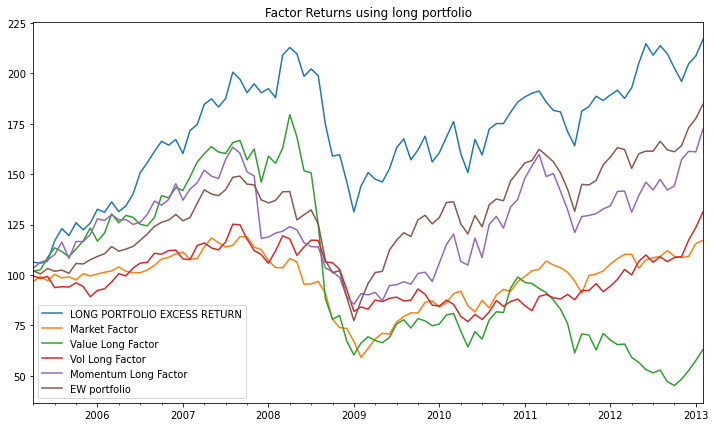

In [35]:
def wealth_index_long(lag):
    
    value_ret(lag)
    vol_ret(lag)
    mom_ret(lag)
    factor_ret_long()
    total_ret(lag)
    factor_ret_long_add()
    factor_ret_short()
    factor_ret_short_add()
    factor_ret()
    factor_ret_add()
    
    df_factor_ret_long_chart = df_factor_ret_long.iloc[:,[0,3,4,5,6]]
    df_factor_ret_long_chart['EW portfolio'] = df_mom_ret['Equal weight return']

    wealth_index1 = 100*(1+df_factor_ret_long_chart).cumprod()
    return wealth_index1.plot(figsize=(12,7), title="Factor Returns using long portfolio")

wealth_index_long(1)


WEALTH INDEX FOR VARIOUS FACTOR STRATEGIES USING SHORT PORTFOLIO

<AxesSubplot:title={'center':'Factor Returns using short portfolio'}>

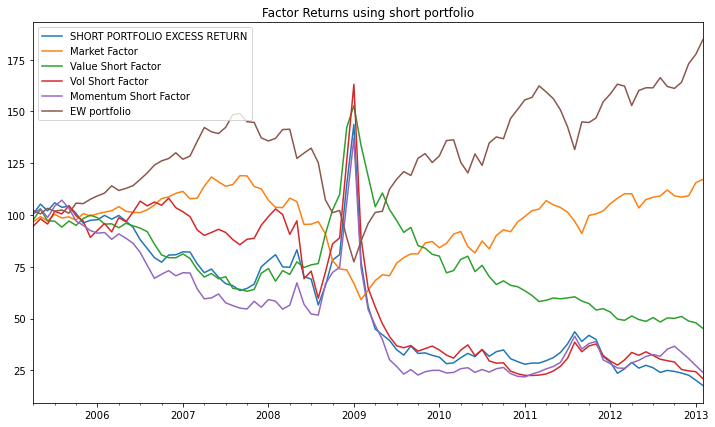

In [36]:

def wealth_index_short(lag):
    
    value_ret(lag)
    vol_ret(lag)
    mom_ret(lag)
    factor_ret_long()
    total_ret(lag)
    factor_ret_long_add()
    factor_ret_short()
    factor_ret_short_add()
    factor_ret()
    factor_ret_add()

    df_factor_ret_short_chart = df_factor_ret_short.iloc[:,[0,3,4,5,6]]
    df_factor_ret_short_chart['EW portfolio'] = df_mom_ret['Equal weight return']

    wealth_index1 = 100*(1+df_factor_ret_short_chart).cumprod()
    return wealth_index1.plot(figsize=(12,7), title="Factor Returns using short portfolio")

wealth_index_short(1)

WEALTH INDEX FOR VARIOUS FACTOR STRATEGIES USING L/S PORTFOLIO

<AxesSubplot:title={'center':'Factor Returns using L/S portfolio'}>

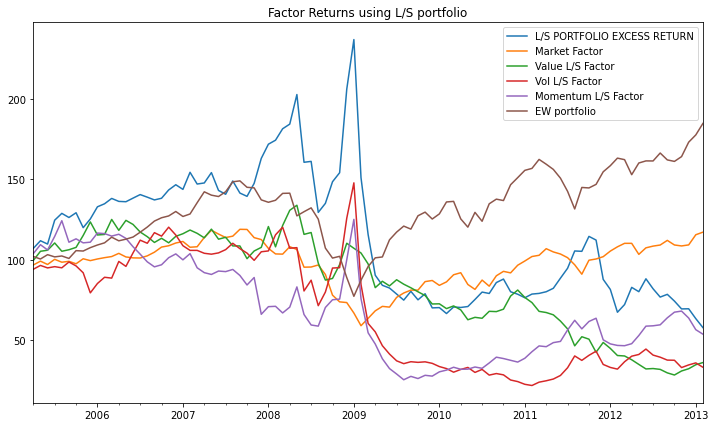

In [38]:
def wealth_index_LS(lag):

    value_ret(lag)
    vol_ret(lag)
    mom_ret(lag)
    factor_ret_long()
    total_ret(lag)
    factor_ret_long_add()
    factor_ret_short()
    factor_ret_short_add()
    factor_ret()
    factor_ret_add()

    df_factor_ret_chart = df_factor_ret.iloc[:,[0,3,4,5,6]]
    df_factor_ret_chart['EW portfolio'] = df_mom_ret['Equal weight return']

    wealth_index1 = 100*(1+df_factor_ret_chart).cumprod()
    return wealth_index1.plot(figsize=(12,7), title="Factor Returns using L/S portfolio")

wealth_index_LS(1)

PORTFOLIO STATS FOR VARIOUS FACTOR STRATEGIES

In [39]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    ann_ex_ret = annualize_rets(r, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def summary_stats(r):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    semid = r.aggregate(semideviation)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd,
        "Semideviation": semid
    })


PORTFOLIO STATS FOR FACTOR STRATEGIES USING LONG ONLY PORTFOLIO

In [40]:
def portfolio_stats_long(lag):
    
    value_ret(lag)
    vol_ret(lag)
    mom_ret(lag)
    factor_ret_long()
    total_ret(lag)
    factor_ret_long_add()
    factor_ret_short()
    factor_ret_short_add()
    factor_ret()
    factor_ret_add()
    
    global df_factor_ret_long_summary  
    
    df_factor_ret_long_summary = df_factor_ret_long.iloc[:,[0,3,4,5,6]]
    df_factor_ret_long_summary['EW portfolio'] = df_mom_ret['Equal weight return']
    
    return summary_stats(df_factor_ret_long_summary)

portfolio_stats_long(1)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,Semideviation
LONG PORTFOLIO EXCESS RETURN,0.102637,0.164592,0.623588,-0.383229,0.028786
Market Factor,0.020237,0.146598,0.138046,-0.503140,0.032863
Value Long Factor,-0.056578,0.264460,-0.213938,-0.748214,0.057146
Vol Long Factor,0.034956,0.142535,0.245247,-0.385932,0.026516
Momentum Long Factor,0.071090,0.190203,0.373758,-0.476530,0.040216
EW portfolio,0.080584,0.164931,0.488593,-0.480984,0.038132


PORTFOLIO STATS FOR FACTOR STRATEGIES USING SHORT ONLY PORTFOLIO

In [41]:
def portfolio_stats_short(lag):
    
    value_ret(lag)
    vol_ret(lag)
    mom_ret(lag)
    factor_ret_long()
    total_ret(lag)
    factor_ret_long_add()
    factor_ret_short()
    factor_ret_short_add()
    factor_ret()
    factor_ret_add()
    
    global df_factor_ret_short_summary

    df_factor_ret_short_summary = df_factor_ret_short.iloc[:,[0,3,4,5,6]]
    df_factor_ret_short_summary['EW portfolio'] = df_mom_ret['Equal weight return']
    
    return summary_stats(df_factor_ret_short_summary)

portfolio_stats_short(1)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,Semideviation
SHORT PORTFOLIO EXCESS RETURN,-0.196759,0.376098,-0.523158,-0.877218,0.077907
Market Factor,0.020237,0.146598,0.138046,-0.503140,0.032863
Value Short Factor,-0.095394,0.213196,-0.447446,-0.704103,0.030854
Vol Short Factor,-0.179130,0.393893,-0.454768,-0.871506,0.080937
Momentum Short Factor,-0.164901,0.396435,-0.415959,-0.840871,0.080482
EW portfolio,0.080584,0.164931,0.488593,-0.480984,0.038132


PORTFOLIO STATS FOR FACTOR STRATEGIES USING L/S PORTFOLIO

In [42]:
def portfolio_stats_LS(lag):
    
    value_ret(lag)
    vol_ret(lag)
    mom_ret(lag)
    factor_ret_long()
    total_ret(lag)
    factor_ret_long_add()
    factor_ret_short()
    factor_ret_short_add()
    factor_ret()
    factor_ret_add()
    
    global df_factor_ret_LS_summary

    df_factor_ret_LS_summary = df_factor_ret.iloc[:,[0,3,4,5,6]]
    df_factor_ret_LS_summary['EW portfolio'] = df_mom_ret['Equal weight return']

    return summary_stats(df_factor_ret_LS_summary)

portfolio_stats_LS(1)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,Semideviation
L/S PORTFOLIO EXCESS RETURN,-0.066637,0.321140,-0.207502,-0.755324,0.078360
Market Factor,0.020237,0.146598,0.138046,-0.503140,0.032863
Value L/S Factor,-0.120384,0.233690,-0.515144,-0.787207,0.042647
Vol L/S Factor,-0.129666,0.356193,-0.364032,-0.851310,0.078582
Momentum L/S Factor,-0.075209,0.357151,-0.210580,-0.795856,0.082894
EW portfolio,0.080584,0.164931,0.488593,-0.480984,0.038132


End of the Code